In [3]:
import librosa
from strechableNumpyArray import StrechableNumpyArray
import numpy as np
import os

pathToBaseDatasetFolder = 'sc09/'
folderNames = ['test']#, 'test', 'valid']
dirs = [pathToBaseDatasetFolder+folderName for folderName in folderNames]
audios = StrechableNumpyArray()
i = 0
total = 0
print('start')
for directory in dirs:
    print(directory)
    for file_name in os.listdir(directory):
        if file_name.endswith('.wav'):      
            audio, sr = librosa.load(directory + '/' + file_name, sr=None, dtype=np.float64)

            if len(audio) < 16000:
                before = int(np.floor((16000-len(audio))/2))
                after = int(np.ceil((16000-len(audio))/2))
                audio = np.pad(audio, (before, after), 'constant', constant_values=(0, 0))
            if len(audio) > 16000: 
                print(file_name, "is too long: ", len(audio))
            if np.sum(np.absolute(audio)) < len(audio)*1e-4: 
                print(file_name, "doesn't meet the minimum amplitude requirement")
                continue

            audios.append(audio[:16000])
            i+=1

            if i > 1000:
                i -= 1000
                total += 1000
                print("1000 plus!", total)
print("there were:", total+i)

audios = audios.finalize()
audios = np.reshape(audios, (total+i, len(audio))).astype(np.float64)
print("audios shape:", audios.shape)


start
sc09/test
there were: 462
audios shape: (462, 16000)


In [4]:
from IPython.display import display, Audio

for i in range(0, audios.shape[0], audios.shape[0]//10):
    display(Audio(audios[i], rate=16000))

In [155]:
from ourLTFATStft import LTFATStft
import ltfatpy
from modGabPhaseGrad import modgabphasegrad
ltfatpy.gabphasegrad = modgabphasegrad # This function is not implemented for one sided stfts with the phase method on ltfatpy

fft_hop_size = 128
fft_window_length = 512
L = 16384
clipBelow = -10

anStftWrapper = LTFATStft()
spectrograms = np.zeros([len(audios), int(fft_window_length//2+1), int(L/fft_hop_size)], dtype=np.float64)
tgrads = np.zeros([len(audios), int(fft_window_length//2+1), int(L/fft_hop_size)], dtype=np.float64)
fgrads = np.zeros([len(audios), int(fft_window_length//2+1), int(L/fft_hop_size)], dtype=np.float64)
print(spectrograms.shape)
gs = {'name': 'gauss', 'M': fft_window_length}
    
for index, audio in enumerate(audios):
    realDGT = anStftWrapper.oneSidedStft(signal=audio, windowLength=fft_window_length, hopSize=fft_hop_size)
    spectrogram = anStftWrapper.logMagFromRealDGT(realDGT, clipBelow=np.e**clipBelow, normalize=True)
    spectrograms[index] = spectrogram  
    tgradreal, fgradreal = ltfatpy.gabphasegrad('abs', np.abs(realDGT), gs, fft_hop_size)
    tgrads[index] = tgradreal #/64
    fgrads[index] = fgradreal #/256


(462, 257, 128)


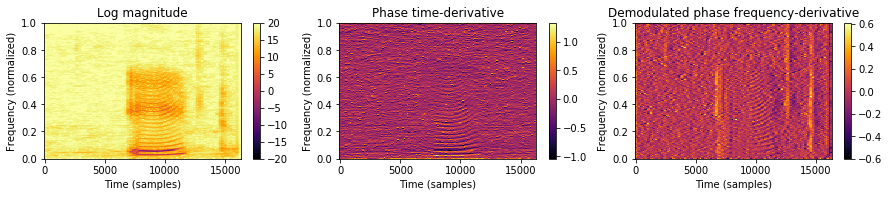

In [23]:
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt

c     = spectrograms[10]
tgrad = tgrads[10]
fgrad = fgrads[10]
a     = 128
M     = 512

mpl.rcParams['image.cmap'] =  'inferno'
plt.figure(figsize=(15,2.5));
plt.subplot(131);
ltfatpy.plotdgtreal(c,a,M,dynrange=40);
plt.title('Log magnitude')
plt.subplot(132);
ltfatpy.plotdgtreal(tgrad*(np.abs(c) > np.exp(-5)),a,M, normalization='lin');
plt.title('Phase time-derivative')
plt.subplot(133);
ltfatpy.plotdgtreal(fgrad*(np.abs(c) > np.exp(-5)),a,M, normalization='lin');
plt.title('Demodulated phase frequency-derivative')
plt.savefig("intro-TF.pdf", bbox_inches='tight')


In [29]:
c.shape

(257, 128)

In [307]:
import heapq

def pghi(spectrogram, tgrad, fgrad, a, M, L, tol=10):
    M2 = spectrogram.shape[0]
    N = spectrogram.shape[1]
    b =  L / M;
    sampToRadConst =  2.0 * np.pi / L;
    
    # Do abstol thingy
    abstol = -50
    
    tgradw = np.zeros_like(spectrogram)
    fgradw = np.zeros_like(spectrogram)

    for m in range(spectrogram.shape[0]):
        for n in range(spectrogram.shape[1]):
            tgradw[m, n] =  a * tgrad[m, n] * sampToRadConst
            fgradw[m, n] = - b * ( fgrad[m, n] + n * a ) * sampToRadConst
            
    phase = np.zeros_like(spectrogram)
    done_mask = np.zeros_like(spectrogram)
    max_val = np.amax(spectrogram[done_mask == 0])
    max_pos = np.where(spectrogram==max_val)
    
    if max_val <= abstol:
        print('Empty spectrogram')
        return phase
    
    magnitude_heap = []
    heapq.heappush(magnitude_heap, (-max_val, max_pos))
    done_mask[max_pos] = 1
    done_mask[spectrogram < max_val-tol] = 3 

    something_is_left = True
    while something_is_left:
        heap_is_not_empty = True
        while True:
            try:
                max_val, max_pos = heapq.heappop(magnitude_heap)
            except IndexError:
                break
                
            #Spread to 4 direct neighbors
            N_pos = max_pos[0]+1, max_pos[1]
            S_pos = max_pos[0]-1, max_pos[1]
            E_pos = max_pos[0], max_pos[1]+1
            W_pos = max_pos[0], max_pos[1]-1

            if max_pos[0] < M2-1 and not done_mask[N_pos]:
                phase[N_pos] = phase[max_pos] + (fgradw[max_pos] + fgradw[N_pos])/2
                done_mask[N_pos] = 2
                heapq.heappush(magnitude_heap, (-spectrogram[N_pos], N_pos))

            if max_pos[0] > 0 and not done_mask[S_pos]:
                phase[S_pos] = phase[max_pos] - (fgradw[max_pos] + fgradw[S_pos])/2
                done_mask[S_pos] = 2
                heapq.heappush(magnitude_heap, (-spectrogram[S_pos], S_pos))

            if max_pos[1] < N-1 and not done_mask[E_pos]:
                phase[E_pos] = phase[max_pos] + (tgradw[max_pos] + tgradw[E_pos])/2
                done_mask[E_pos] = 2
                heapq.heappush(magnitude_heap, (-spectrogram[E_pos], E_pos))

            if max_pos[1] > 0 and not done_mask[W_pos]:
                phase[W_pos] = phase[max_pos] - (tgradw[max_pos] + tgradw[W_pos])/2
                done_mask[W_pos] = 2
                heapq.heappush(magnitude_heap, (-spectrogram[W_pos], W_pos))
        
        try:
            max_val = np.amax(spectrogram[done_mask == 0])
            max_pos = np.where(spectrogram==max_val)
        except ValueError:
            return phase
        max_val = spectrogram[max_pos]
        heapq.heappush(magnitude_heap, (-max_val, max_pos))
        done_mask[max_pos] = 1

        

In [308]:
c     = spectrograms[-1]
tgrad = tgrads[-1]
fgrad = fgrads[-1]
a     = 128
M     = 512

tgradreal, fgradreal = ltfatpy.gabphasegrad('phase', np.angle(realDGT), fft_hop_size, 512)

phase = pghi(c, tgrad, fgrad, a, M, L, tol=15)

In [309]:
original_time_signal = anStftWrapper.reconstructSignalFromLoggedSpectogram(spectrogram, np.angle(realDGT), windowLength=fft_window_length, hopSize=fft_hop_size)
time_signal = anStftWrapper.reconstructSignalFromLoggedSpectogram(c, phase, windowLength=fft_window_length, hopSize=fft_hop_size)

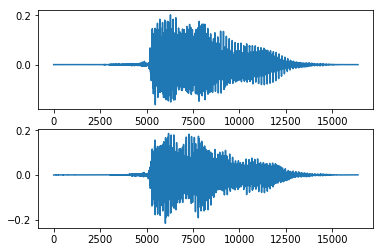

In [310]:
plt.subplot(211)
plt.plot(original_time_signal)
plt.subplot(212)
plt.plot(time_signal)
display(Audio(original_time_signal, rate=16000))
display(Audio(time_signal, rate=16000))